# Zaitsev Anton | Exercise 2

## General Information

This exercise focuses on constructing further analysis of *Facebook* and *Twitter* social networks represented as graphs. The analysis is performed with the help of the *networkx* library in Python, and the analysis includes:
1. Calculating the degree distribution of the network; 
2. Differentiating between the chosen network and a random network with the same number of nodes;
3. Calculating average path;
4. Choosing 5 random nodes and calculating the clustering coefficients of these nodes;
5. Calculating average clustering coefficient;
6. Listing the nodes that compose the largest component (giant component) in the network


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import Counter

# global variables
DATA_FOLDER = "../data/"

def construct_graph(edges_path: str, directed: bool = False) -> nx.Graph:
    """
    Construct a graph from an edge list.

    Parameters:
        - edges_path (str): The path to the .edges file, which contains the edges of the graph.
        - directed (bool): If True, the graph will be treated as directed, creating a NetworkX DiGraph.
    
    Returns:
        - g (nx.Graph or nx.DiGraph): A NetworkX graph containing all the nodes and edges from the .edges file.
                                      Additionally, nodes present in the .feat file but missing in the .edges
                                      file will be added to the graph as disconnected nodes (without any edges).
    """
    # read graph from .edges file
    if directed:
        g = nx.read_edgelist(edges_path, create_using=nx.DiGraph(), nodetype=int)
    else:
        g = nx.read_edgelist(edges_path, create_using=nx.Graph(), nodetype=int)
    return g

In [2]:
# load facebook network, indirected graph
G_fb = construct_graph(edges_path=f"{DATA_FOLDER}3437.edges", directed=False)
# load twitter network, directed graph
G_tw = construct_graph(edges_path=f"{DATA_FOLDER}3253671.edges", directed=True)

## Question **a**

To find and plot the degree distribution, we can use the formula:

$$P(k)=\frac{N_k}{N}$$

with $N_k = \#$ of nodes with degree $k$.

In [3]:
def plot_degree_distribution(G: nx.Graph, network_name: str):
    """
    Calculates & plots the degree distribution of a graph.
    
    Parameters:
        - G (networkx.Graph or networkx.DiGraph): The input graph.
        - network_name (str): The name of the network for the plot title.
    """
    # for directed graphs
    if isinstance(G, nx.DiGraph):
        degrees = [G.degree(n) for n in G.nodes()]
    # for undirected graphs
    else:
        degrees = [G.degree(n) for n in G.nodes()]

    # calculate degree distribution
    degree_count = Counter(degrees)
    x, y = zip(*sorted(degree_count.items()))
    # plot the degree distribution
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, 'bo-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title(f'Degree Distribution of {network_name} Network')
    plt.grid(True)
    plt.show()

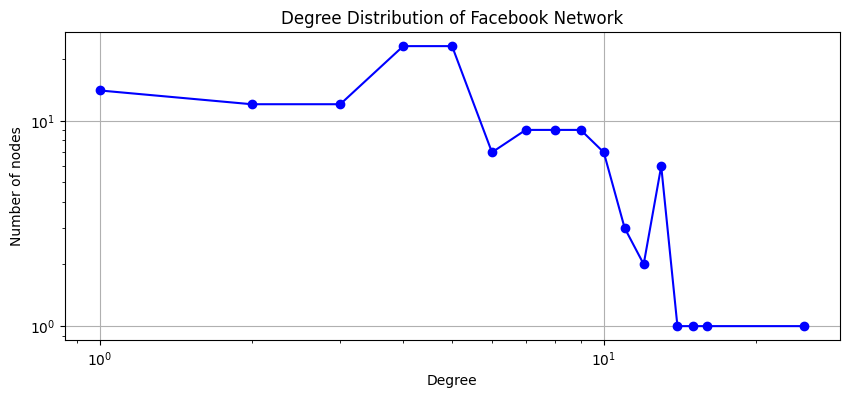

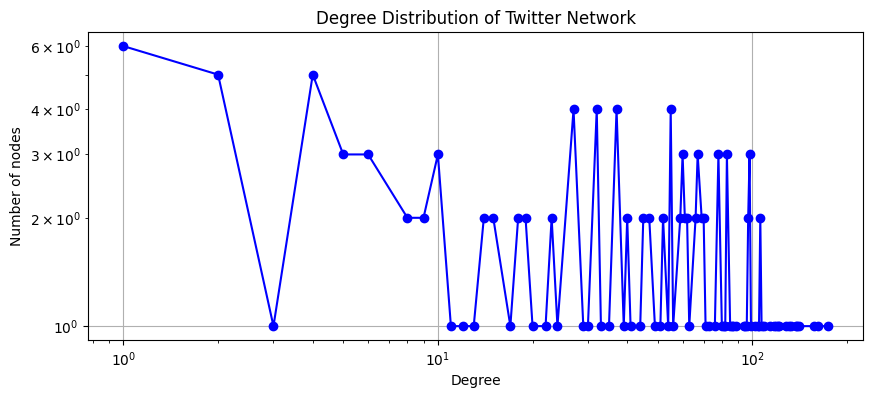

In [4]:
plot_degree_distribution(G_fb, "Facebook")
plot_degree_distribution(G_tw, "Twitter")

## Question **b**

According to the theory, the degree distribution of the random network is Poissonian, centered around an average degree and as the network size increases, the distribution becomes increasingly narrow. It would be logical to assume that, for example, Twitter network would also follow some kind of a normal degree distribution, which it does not and it is suprising. There is a wide variation in node degrees, with a small number of very highly connected nodes and many nodes with few connections.

The reason for this is how the random networks are constructed, which is a random process. Real life networks, specifically social networks, often have high clustering and community structure. Also, it is important to note that real-world networks update based on specific dynamics such as social interactions (e.g. friends introducing friends) or information flow (e.g. retweets on Twitter). These processes introduce correlations between node degrees. Remember that while building a random network each edge appears i.i.d.

## Question **c**

To compute the average shortest path length for **undirected** graph we must have a connected graph. Else, we can do the following:
1. Find the largest connected component and compute its average path length.
2. For each connected component in the graph weigh the contribution of each connected component by the number of pairs of nodes within that component. The algorithm is the following:
   1. Compute the number of node pairs in each component: $\frac{n(n-1)}{2}$
   2. Compute the average path length for each component.
   3. Weigh each component's average path length by the number of node pairs.
   4. Sum the weighted path lengths and divide by the total number of node pairs in the graph.
   
For undirected *Facebook* graph We will use method 2 in this solution.

For **directed** graphs there are two ways to compute average path length depending on the type of connectedness we are interested in: **strongly connected components** (including direction) or **weakly connected components** (excluding direction). So, to compute average path length for a directed graph we will first need to identify strongly connected components and then use method 2 for undirected graphs.

In [5]:
def average_path_length(G: nx.Graph) -> float:
    """
    Calculates average path length of a given network.
    
    Parameters:
        - G (networkx.Graph or networkx.DiGraph): The input graph.
    
    Returns:
        - (float): average path length of a given network.
    """
    # identify connected / strongly connected components
    if isinstance(G, nx.DiGraph):
        components = [G.subgraph(c).copy() for c in nx.strongly_connected_components(G)]
    else:
        # check if the graph is connected
        if nx.is_connected(G):
            return nx.average_shortest_path_length(G)
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    # use method 2 to calculate average path length
    total_pairs = 0
    total_weighted_path_length = 0
    for component in components:
        n = component.number_of_nodes()
        if n > 1:
            # number of pairs in this component
            num_pairs = n * (n - 1) if isinstance(G, nx.DiGraph) else n * (n - 1) / 2
            # average path length for this component
            avg_path_length_component = nx.average_shortest_path_length(component)
            # weighted sum contribution from this component
            total_weighted_path_length += avg_path_length_component * num_pairs
            total_pairs += num_pairs
    # if the graph is completely disconnected, return infinity
    if total_pairs == 0:
        return float('inf')
    return total_weighted_path_length / total_pairs

In [6]:
avg_path_len_fb = average_path_length(G=G_fb)
avg_path_len_tw = average_path_length(G=G_tw)
print(f"Average path length, Facebook: {round(avg_path_len_fb, 3)}")
print(f"Average path length, Twitter (strongly connected components): {round(avg_path_len_tw, 3)}")

Average path length, Facebook: 4.512
Average path length, Twitter (strongly connected components): 1.953


## Question **d**

In [7]:
def get_random_nodes(G: nx.Graph, num_nodes=5) -> list:
    """
    Selects a specified number of random nodes from the graph.
    
    Parameters:
        - G (networkx.Graph or networkx.DiGraph): The input graph.
        - num_nodes (int): Number of random nodes to select (default is 5).
    
    Returns:
        - nodes (list): A list of randomly selected nodes.
    """
    nodes = list(G.nodes)
    return random.sample(nodes, num_nodes)

In [8]:
def calculate_clustering_coefficients(G: nx.Graph, nodes: list) -> dict:
    """
    Calculates the clustering coefficient for each node in the list.
    
    Parameters:
        - G (networkx.Graph or networkx.DiGraph): The input graph.
        - nodes (list): A list of nodes for which to calculate the clustering coefficients.
    
    Returns:
        - (dict): A dictionary where the keys are node IDs and the values are the clustering coefficients.
    """
    return {node: nx.clustering(G, node) for node in nodes}

In [9]:
# get 5 random nodes from the Facebook and Twitter networks
random_nodes_fb = get_random_nodes(G=G_fb, num_nodes=5)
random_nodes_tw = get_random_nodes(G=G_tw, num_nodes=5)
# calculate clustering coefficients
clustering_coeffs_fb = calculate_clustering_coefficients(G=G_fb, nodes=random_nodes_fb)
clustering_coeffs_tw = calculate_clustering_coefficients(G=G_tw, nodes=random_nodes_tw)
print("Clustering coefficients for 5 randomly selected nodes in Facebook network:")
for node, coeff in clustering_coeffs_fb.items():
    print(f"Node {node}: {round(coeff, 3)}")
print("\nClustering coefficients for 5 randomly selected nodes in Twitter network:")
for node, coeff in clustering_coeffs_tw.items():
    print(f"Node {node}: {round(coeff, 3)}")

Clustering coefficients for 5 randomly selected nodes in Facebook network:
Node 3579: 0.833
Node 3540: 0.244
Node 3567: 1.0
Node 3551: 0.4
Node 3443: 0.667

Clustering coefficients for 5 randomly selected nodes in Twitter network:
Node 18666844: 0.355
Node 16030324: 0.566
Node 235766196: 0.294
Node 1247691: 0.58
Node 245487159: 0.543


## Question **e**

In [10]:
def calculate_average_clustering_coefficient(G: nx.Graph) -> float:
    """
    Calculates the average clustering coefficient for the graph.
    Calculates clustering coefficient for each node in G, sums them up and divides the sum by the total number of nodes in G.
    
    Parameters:
        - G (networkx.Graph or networkx.DiGraph): The input graph.
    
    Returns:
        - (float): The average clustering coefficient of the graph.
    """
    return nx.average_clustering(G)

# calculate the average clustering coefficient for the Facebook and Twitter networks
avg_clustering_fb = calculate_average_clustering_coefficient(G_fb)
avg_clustering_tw = calculate_average_clustering_coefficient(G_tw)
print(f"Average clustering coefficient of the Facebook network: {round(avg_clustering_fb, 3)}")
print(f"Average clustering coefficient of the Twitter network: {round(avg_clustering_tw, 3)}")

Average clustering coefficient of the Facebook network: 0.468
Average clustering coefficient of the Twitter network: 0.481


## Question **f**

In [11]:
def get_nodes_from_largest_comp(G: nx.Graph) -> list:
    """
    Finds largest connected component in G and returns the list of its nodes.
    If G is directed, search among the strongly connected components.
    
    Parameters:
        - G (networkx.Graph or networkx.DiGraph): The input graph.
    
    Returns:
        - (list): The list of the nodes of the largest connected component of G.
    """
    if isinstance(G, nx.DiGraph):
        components = [G.subgraph(c).copy() for c in nx.strongly_connected_components(G)]
        largest_cc = list(max(components, key=len))
    else:
        largest_cc = list(max(nx.connected_components(G), key=len))
    return largest_cc

In [12]:
nodes_largest_comp_fb = get_nodes_from_largest_comp(G_fb)
nodes_largest_comp_tw = get_nodes_from_largest_comp(G_tw)
print(f"List of nodes from the largest connected component in the Facebook graph:\n{nodes_largest_comp_fb}")
print(f"\nList of nodes from the largest strongly connected component in the Twitter graph:\n{nodes_largest_comp_tw}")

List of nodes from the largest connected component in the Facebook graph:
[567, 1085, 698, 857, 862, 3438, 3440, 3441, 3442, 3443, 3445, 3446, 3447, 3448, 3449, 3450, 3452, 3454, 3455, 3456, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3478, 3480, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3514, 3515, 3517, 3518, 3520, 3521, 3522, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3538, 3539, 3540, 3541, 3542, 3543, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3561, 3563, 3564, 3566, 3567, 3568, 3569, 3572, 3573, 3574, 3576, 3577, 3578, 3580, 3582, 3583]

List of nodes from the largest strongly connected component in the Twitter graph:
[16834674, 15913, 3062761, 14269220, 1937751, 16547411, 4065921, 6085372, 14168488, 59804598, 15